In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import time
import pandas as pd
import os
import seaborn as sns
# from keras.applications.InceptionV3 import InceptionV3
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.layers import MaxPool2D ,ReLU,Lambda,TimeDistributed,Dense, GlobalAveragePooling2D, Dropout,LSTM,Conv2D,MaxPooling2D,Flatten,BatchNormalization
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import CSVLogger

import os
import random

import numpy as np
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from PIL import Image, ImageOps
import matplotlib.image as mpimg

from keras.models import model_from_json

In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def remove_background(img):
    #img1 = rgb2gray(img)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = img
    #blur = cv2.GaussianBlur(img1,(3,3),0)
    #ret,thresh1 = cv2.threshold(img1,225,255,cv2.THRESH_BINARY_INV)
    thresh1 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,133,5)
    
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    b,g,r = cv2.split(img2)
    for i in range(closing.shape[0]):
      for j in range(closing.shape[1]):
        if(closing[i,j])==0:
          b[i,j] = 0
          g[i,j] = 0
          r[i,j] = 0

    newimg = cv2.merge((b,g,r))
    return newimg

In [ ]:
def LoadPreProcessesAndSave(imgPath, savePath):
    img = plt.imread(imgPath)
    #plt.imshow(img)
    img = remove_background(img)
    #plt.imshow(img)
    #plt.imsave(img, savePath)
    plt.imsave(savePath,img)
    #img.save(savePath)
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' '/content'

In [ ]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:

!kaggle datasets download -d samirimtiaz/isharalipi-sign-language

 68% 5.00M/7.34M [00:00<00:00, 31.5MB/s]
100% 7.34M/7.34M [00:00<00:00, 43.6MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('isharalipi-sign-language.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
# cv2.imread("/content/isharalipi/database/training_set/").shape

In [ ]:
batch_size = 50
image_height= 75
image_width= 75
train_path = '/content/isharalipi/gestures/training_set'     

test_path =  '/content/isharalipi/gestures/testing_set'  
train_datagenerator = ImageDataGenerator(
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        rescale=1./255,
vertical_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range=0.3,
    rotation_range=15,
)

test_datagenerator = ImageDataGenerator(rescale=1./255)
train_generator = train_datagenerator.flow_from_directory(train_path,
                                                          target_size = (75,75),
                                                          color_mode = 'rgb',
                                                          batch_size = batch_size,
                                                          class_mode = 'categorical',
                                                          shuffle = True)


test_generator = test_datagenerator.flow_from_directory(test_path,
                                                        target_size = (75,75),
                                                        color_mode = 'rgb',
                                                        class_mode = 'categorical',
                                                       shuffle=False
                                                       )

from keras.layers import Input, Conv2D, Lambda, Concatenate, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam

model = tf.keras.applications.InceptionResNetV2(
    include_top=None,
    
    input_tensor=None,
    input_shape=(75,75,3),
    pooling=None,
    classes=10,
    classifier_activation="softmax",
   
)

model.summary()

flat1 = Flatten()(model.layers[-1].output)

class1 = Dense(512, activation='relu')(flat1)
# class2 = Dropout(0.2)(class1)
class3 = Dense(256, activation='relu')(class1)
# class4 = Dropout(0.2)(class3)
class5 = Dense(128, activation='relu')(class3)
# class6 = Dropout(0.2)(class5)
class7 = Dense(64, activation='relu')(class5)
# class8 = Dropout(0.2)(class7)

x = class7
output = Dense(10, activation='softmax')(x)
# define new model
model = Model(inputs=model.inputs, outputs=output)

# model = tf.keras.models.Sequential([
#     tf.keras.layers.ZeroPadding2D(padding=(3, 3), input_shape=(75,75,3)),
#     # 1st
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     #2nd
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2), 
#     # 3rd
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # 4th
#     tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2,2),
#     # 5th
#     # tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
#     # tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.MaxPooling2D(2,2),
#     # full connect
#     tf.keras.layers.Flatten(), 
#     tf.keras.layers.Dense(128, activation='relu'), 
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(36,activation='softmax')  
# ])

model.summary()
model.compile(optimizer = keras.optimizers.SGD(learning_rate=keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),loss='categorical_crossentropy',metrics = ['accuracy'])

Found 925 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
219055592/219055592 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                            

In [ ]:
start_time = time.time()

csv_logger = CSVLogger('training_InceptionV3_rd_forest_digit.log', separator=',', append=False)
history1=model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//batch_size,
        epochs= 200,
        validation_data=train_generator,
        validation_steps=train_generator.samples//batch_size,
        callbacks=[csv_logger]
)

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/200
18/18 [==============================] - 35s 512ms/step - loss: 2.3272 - accuracy: 0.1143 - val_loss: 3.2178 - val_accuracy: 0.0933
Epoch 2/200
18/18 [==============================] - 5s 248ms/step - loss: 2.2602 - accuracy: 0.1703 - val_loss: 2.3924 - val_accuracy: 0.1256
Epoch 3/200
18/18 [==============================] - 4s 246ms/step - loss: 2.2187 - accuracy: 0.1920 - val_loss: 3.2362 - val_accuracy: 0.1578
Epoch 4/200
18/18 [==============================] - 4s 248ms/step - loss: 2.1416 - accuracy: 0.2503 - val_loss: 2.6399 - val_accuracy: 0.1778
Epoch 5/200
18/18 [==============================] - 4s 250ms/step - loss: 1.9914 - accuracy: 0.3211 - val_loss: 3.1238 - val_accuracy: 0.2756
Epoch 6/200
18/18 [==============================] - 4s 245ms/step - loss: 1.8472 - accuracy: 0.3794 - val_loss: 2.5119 - val_accuracy: 0.3544
Epoch 7/200
18/18 [==============================] - 5s 267ms/step - loss: 1.7374 - accuracy: 0.4217 - val_loss: 2.2480 - val_accuracy: 0.405

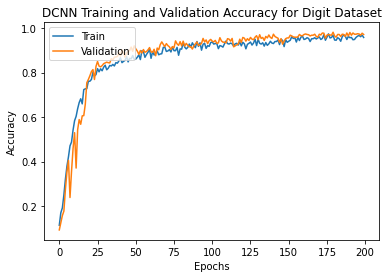

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('DCNN Training and Validation Accuracy for Digit Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

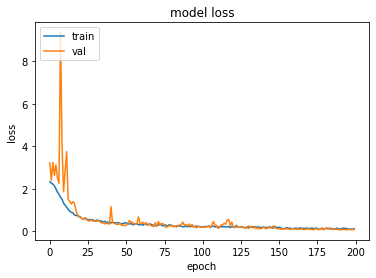

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_InceptionV3_digits.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_InceptionV3_digits.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model_pred = model.evaluate(test_generator)

5/5 [==============================] - 1s 172ms/step - loss: 0.2715 - accuracy: 0.9200


In [ ]:
fe =  Model(inputs=model.inputs, outputs=model.layers[-2].output)
fe.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]

In [ ]:
# Read input images and assign labels based on folder names
# print(os.listdir("/kaggle/input/isharalipi-characters/database/training/"))

SIZE = 75  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/isharalipi/gestures/training_set/*"):
    label = directory_path.split("/")[-1]
#     print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
#         print(img_path)
#         print("done")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
train_images.shape

In [ ]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/isharalipi/gestures/testing_set/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

test_labels.shape

(150,)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
test_labels_encoded.shape

In [ ]:
x_train = train_images
y_train = train_labels_encoded
x_test = test_images
y_test= test_labels_encoded

In [ ]:
y_train.shape

In [ ]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train,128)
y_test_one_hot = to_categorical(y_test,128)

In [ ]:
y_train_one_hot.shape

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


29/29 [==============================] - 1s 35ms/step
--- 0.23045992851257324 seconds ---
5/5 [==============================] - 0s 31ms/step
Accuracy =  0.9666666666666667
[14  0  0  0  0  0  0  0  0  1]
[ 0 15  0  0  0  0  0  0  0  0]
[ 0  0 15  0  0  0  0  0  0  0]
[ 0  0  0 15  0  0  0  0  0  0]
[ 0  0  0  0 13  2  0  0  0  0]
[ 0  0  0  0  0 15  0  0  0  0]
[ 1  0  0  0  0  0 13  0  0  1]
[ 0  0  0  0  0  0  0 15  0  0]
[ 0  0  0  0  0  0  0  0 15  0]
[ 0  0  0  0  0  0  0  0  0 15]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      0.87      0.93        15
           5       0.88      1.00      0.94        15
           6       1.00      0.87      0.93        15
           7       1.00      1.00      1.00        15
           8       1

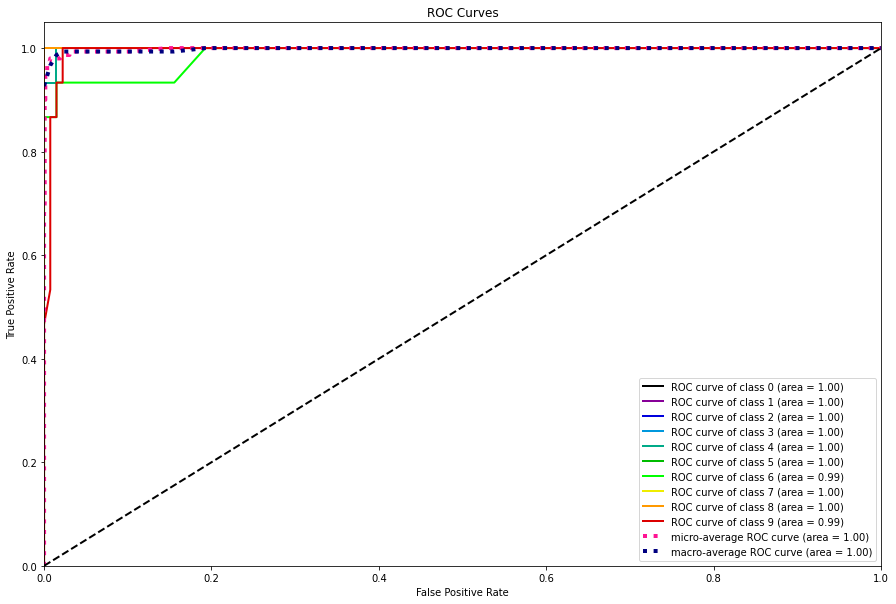

1/1 [==============================] - 0s 465ms/step
The prediction for this image is:  ['2']
The actual label for this image is:  2


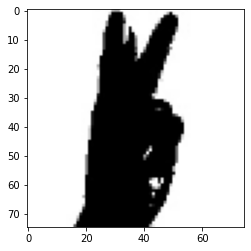

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0



#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#############################

# #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
# for layer in VGG_model.layers:
# 	layer.trainable = False
    
# VGG_model.summary()  #Trainable parameters will be 0




#Now, let us use features from convolutional network for RF

feature_extractor=fe.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier()
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
model1 =GridSearchCV(RF_model, param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Train the model on training data
start_time = time.time()

RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

print("--- %s seconds ---" % (time.time() - start_time))

#Send test data through same feature extractor process
X_test_feature = fe.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RFs = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RFs)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(test_labels, prediction_RF)
# #print(cm)
# sns.heatmap(cm, annot=True)
for i in confusion_matrix(test_labels, prediction_RF):
    print(i)
import sklearn.metrics as metrics
report = metrics.classification_report(y_test, prediction_RFs)
print(report)

import scikitplot as skplt
import matplotlib.pyplot as plt

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_test,RF_model.predict_proba(X_test_features), figsize = (15,10))
plt.show()


#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=fe.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

29/29 [==============================] - 2s 64ms/step
--- 0.024077653884887695 seconds ---
5/5 [==============================] - 0s 49ms/step
Accuracy =  0.9133333333333333
[12  0  0  0  0  0  1  0  0  2]
[ 0 15  0  0  0  0  0  0  0  0]
[ 0  0 15  0  0  0  0  0  0  0]
[ 0  0  0 15  0  0  0  0  0  0]
[ 0  0  1  1 13  0  0  0  0  0]
[ 0  0  0  0  0 14  0  0  1  0]
[ 0  1  0  0  0  0 13  0  0  1]
[ 0  0  0  0  0  0  2 13  0  0]
[ 0  0  0  0  0  0  0  0 15  0]
[ 1  0  0  0  0  0  0  2  0 12]


ValueError: ignored

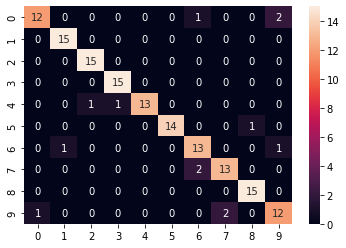

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0



#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)




from sklearn.tree import DecisionTreeRegressor
feature_extractor=fe.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF

#RANDOM FOREST
DT_model=DecisionTreeRegressor( random_state = 42)


# Train the model on training data
start_time = time.time()

DT_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

print("--- %s seconds ---" % (time.time() - start_time))

#Send test data through same feature extractor process
X_test_feature = fe.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RFs =DT_model.predict(X_test_features)
#Inverse le transform to get original label back. 
rounded_down_integer_array = prediction_RFs.astype(int)
prediction_RF =le.inverse_transform(rounded_down_integer_array)


#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)
for i in confusion_matrix(test_labels, prediction_RF):
    print(i)
import sklearn.metrics as metrics
report = metrics.classification_report(y_test, prediction_RF)
print(report)

import scikitplot as skplt
import matplotlib.pyplot as plt

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
# 


#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=fe.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RFs = DT_model.predict(input_img_features)[0] 
rounded_down_integer1_array = prediction_RFs.astype(int)
prediction_RF = le.inverse_transform([rounded_down_integer1_array])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RFs)
print("The actual label for this image is: ", test_labels[n])

29/29 [==============================] - 2s 57ms/step
Fitting 3 folds for each of 96 candidates, totalling 288 fits
--- 142.62406849861145 seconds ---
5/5 [==============================] - 0s 51ms/step
Accuracy =  0.9533333333333334
[14  0  0  0  0  0  0  0  0  1]
[ 0 15  0  0  0  0  0  0  0  0]
[ 0  0 15  0  0  0  0  0  0  0]
[ 0  0  0 15  0  0  0  0  0  0]
[ 0  0  0  1 12  2  0  0  0  0]
[ 0  0  0  0  0 14  0  0  1  0]
[ 1  0  0  0  0  0 13  0  0  1]
[ 0  0  0  0  0  0  0 15  0  0]
[ 0  0  0  0  0  0  0  0 15  0]
[ 0  0  0  0  0  0  0  0  0 15]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       0.94      1.00      0.97        15
           4       1.00      0.80      0.89        15
           5       0.88      0.93      0.90        15
           6       1.00      0.87      0.93        15
           7 

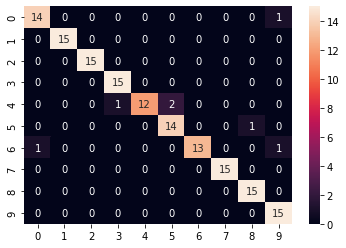

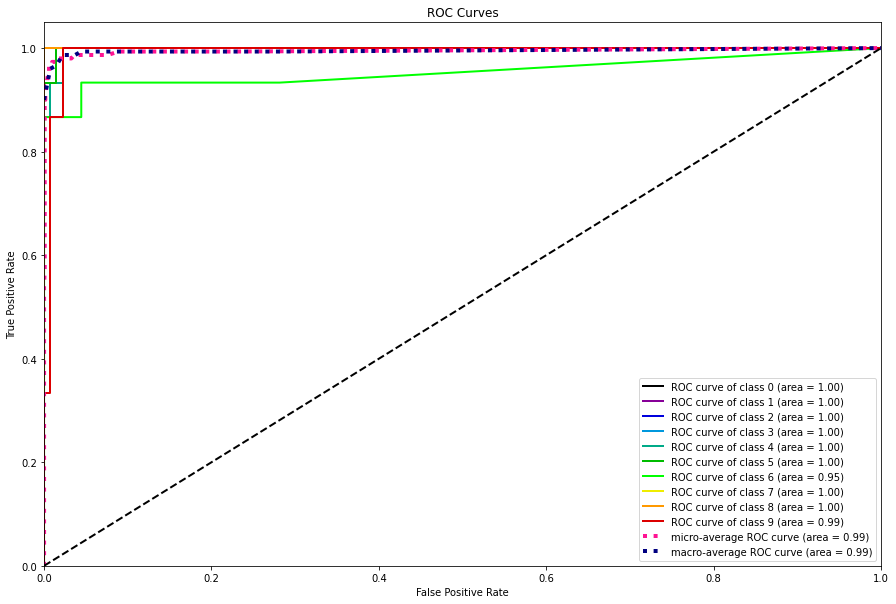

1/1 [==============================] - 0s 37ms/step
The prediction for this image is:  ['8']
The actual label for this image is:  8


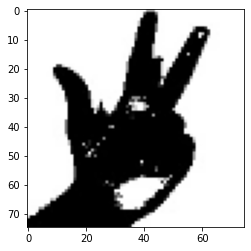

In [ ]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

feature_extractor=fe.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)




X_for_RF = features #This is our X input to RF

#RANDOM FOREST
xgbr =xgb.XGBClassifier()
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2,4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8],
    'n_estimators': [100, 200, 300, 1000]
}
model1 =GridSearchCV(xgbr, param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Train the model on training data
start_time = time.time()

model1.fit(X_for_RF, y_train) #For sklearn no one hot encoding

print("--- %s seconds ---" % (time.time() - start_time))

#Send test data through same feature extractor process
X_test_feature = fe.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RFs= RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
rounded_down_integer_array = prediction_RFs.astype(int)
prediction_RF =le.inverse_transform(rounded_down_integer_array)


#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)
for i in confusion_matrix(test_labels, prediction_RF):
    print(i)
import sklearn.metrics as metrics
report = metrics.classification_report(y_test, prediction_RFs)
print(report)


import scikitplot as skplt
import matplotlib.pyplot as plt

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
# 
skplt.metrics.plot_roc(y_test,RF_model.predict_proba(X_test_features), figsize = (15,10))
plt.show()


#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=fe.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RFs =model1.predict(input_img_features)[0] 
rounded_down_integer1_array = prediction_RFs.astype(int)
prediction_RF = le.inverse_transform([rounded_down_integer1_array])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])




In [ ]:
import joblib

# save
joblib.dump(RF_model, "InceptionV3_rd_forest_characters.joblib")